In [521]:
import requests
import pandas as pd
from getpass import getpass
import json
import time
import string
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text  import CountVectorizer
from collections import Counter, OrderedDict
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt

# Pull NYT articles

In [2]:
base_url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json?'

In [3]:
api_key = getpass()

········


In [303]:
sections = ['Arts','Business','Obituaries','Sports','World']
# number of articles per section
# do 500 so it doesn't take too long
n_articles = 500

In [304]:
final_df = pd.DataFrame()
for section in sections:
    print(section)
    for page in range(1, int(n_articles/10)+1):
        print(page)
        query = f'api-key={api_key}&fq=news_desk:("{section}")&page={page}'
        full_url = base_url + query
        content = requests.get(full_url).json()

        articles_df = pd.DataFrame(content['response']['docs'])
        articles_df['headline'] = [d.get('main') for d in articles_df['headline']]
        # this version of the api doesn't have the body, so combine abstract and lead paragraph
        articles_df['snippet'] = articles_df['abstract'] + ' ' + articles_df['lead_paragraph']
        cols = ['web_url','headline','snippet','section_name']
        articles_df = articles_df[cols]
        final_df = final_df.append(articles_df)
    
        time.sleep(6)

Arts
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Business
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Obituaries
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Sports
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
World
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [306]:
final_df.head()

,web_url,headline,snippet,section_name
0,https://www.nytimes.com/interactive/2020/11/27...,The Best of Late Night This Week,"The late-night hosts took the holiday off, and...",Arts
1,https://www.nytimes.com/interactive/2020/11/25...,"The Myth of North America, in One Painting",How Benjamin West remade a bloody battle as a ...,Arts
2,https://www.nytimes.com/interactive/2020/11/25...,What’s in Our Queue? ‘Down by Law’,I’m the deputy culture editor for news. I’m do...,Arts
3,https://www.nytimes.com/interactive/2020/11/20...,The Best of Late Night This Week,"This week, the late-night hosts crunched the n...",Arts
4,https://www.nytimes.com/interactive/2020/11/19...,What’s in Our Queue? ‘The Great’,I’m the editor of The Times’s Arts & Leisure s...,Arts


In [307]:
final_df.to_csv('raw_articles_output.csv',index=False)

# Preprocessing

In [305]:
final_df['section_name'].value_counts()

World            501
Obituaries       500
Arts             500
Sports           500
Business Day     335
Technology       146
Your Money        14
Times Insider      1
Reader Center      1
Travel             1
New York           1
Name: section_name, dtype: int64

In [308]:
# combining to business
final_df.loc[~final_df['section_name'].isin(['World','Obituaries','Arts','Sports']),'section_name'] = 'Business'

In [309]:
final_df['section_name'].value_counts()

World         501
Obituaries    500
Arts          500
Sports        500
Business      499
Name: section_name, dtype: int64

In [310]:
# clean text
punctuations = string.punctuation
punctuations = punctuations + "’‘“”—"
stopw = stopwords.words('english')
stopw.extend(['new','york','time','2'])

final_df['combined_text'] = final_df['headline'] + ' ' + final_df['snippet']
final_df['combined_text'] = final_df['combined_text'].str.lower()

In [311]:
def removeStopwords(texto):
    
    blob = TextBlob(texto).words
    outputlist = [word for word in blob if word not in stopw
                                        and word not in punctuations]
    text_cleaned = ' '.join(word for word in outputlist)
    text_cleaned = text_cleaned.replace('-',' ')
    return text_cleaned


def tokenize(text):
    stem = nltk.stem.SnowballStemmer('english')
    text = text.lower()

    for token in nltk.word_tokenize(text):
        if token in string.punctuation: continue
        yield stem.stem(token)

In [312]:
final_df['combined_text_cleaned'] = final_df['combined_text'].apply(removeStopwords)

# Implement Bernoulli Naive Bayes

In [331]:
model_df = final_df[['combined_text_cleaned','section_name']].copy()
model_df = model_df.reset_index(drop=True)

In [ ]:
world = model_df[model_df['section_name']=='World'].copy().reset_index(drop=True)
other = model_df[model_df['section_name']!='World'].copy().reset_index(drop=True)

In [855]:
# includes more samples for world section since it has less vocab
# than other sections and keep not getting predicted
world_test_size = 0.50
other_test_size = 0.20

world_test = world.sample(n=int(world_test_size * len(world)))
world_train = world[~world.index.isin(world_test.index)]

other_test = other.sample(n=int(other_test_size * len(other)))
other_train = other[~other.index.isin(other_test.index)]

train = pd.concat([other_train, world_train])
test = pd.concat([other_test, world_test])

In [856]:
train['section_name'].value_counts()

Sports        406
Arts          401
Business      399
Obituaries    394
World         251
Name: section_name, dtype: int64

In [857]:
test['section_name'].value_counts()

World         250
Obituaries    106
Business      100
Arts           99
Sports         94
Name: section_name, dtype: int64

## train

In [933]:
class0 = 'World'
alpha = 10
beta = 60

In [934]:
# using nltk

from collections import defaultdict

def vectorize(doc):
    features = defaultdict(int)
    for token in tokenize(doc):
        features[token] += 1
    return features

In [935]:
# calculate priors
theta_jc_df = pd.DataFrame()
theta_c_df = pd.DataFrame()
ndoc_by_sec = []
for s in sections:

    vectors = map(vectorize, train[train['section_name']==s]['combined_text_cleaned'])

    # change to 0 or 1
    class_df = pd.DataFrame(vectors).fillna(0)
    class_df = class_df.where(class_df==0, 1)
    ndoc_by_sec.append(len(class_df))
    # calculate theta jc
    # number of doc containing word j in section c over total number of docs in section c with laplace
    #thetajc = ((class_df.sum() + alpha - 1)/(len(class_df) + alpha + beta -2))
    thetajc = class_df.sum()
    thetajc = pd.DataFrame(thetajc).T
    thetajc['section'] = s
    theta_jc_df = theta_jc_df.append(thetajc)
    
    thetac = len(class_df)/len(train)
    theta_c_df = theta_c_df.append(pd.DataFrame([{'section':s,'thetac':thetac}]))

In [936]:
ndoc_by_sec = np.array(ndoc_by_sec)
ndoc_by_sec = np.expand_dims(ndoc_by_sec, axis=1)
theta_jc_df = theta_jc_df.fillna(0)
features = [c for c in theta_jc_df.columns if 'section' not in c]
theta_jc_df.loc[:, features] = (theta_jc_df[features] + alpha - 1) / (ndoc_by_sec + alpha + beta -2)

In [937]:
# number of doc  in section c over total number of docs
theta_jc_df = theta_jc_df.set_index('section')
theta_c_df = theta_c_df.set_index('section')

In [938]:
theta_c_df

,thetac
section,
Arts,0.216640
Business,0.215559
Obituaries,0.212858
Sports,0.219341
World,0.135602


In [939]:
theta_jc_df

,best,late,night,week,host,took,holiday,seem,thank,earlier,...,discont,noteworthi,tel,aviv,gilkey,npr,zabihullah,tamanna,videograph,glimps
section,,,,,,,,,,,,,,,,,,,,,
Arts,0.072495,0.031983,0.051173,0.123667,0.036247,0.027719,0.027719,0.027719,0.023454,0.023454,...,0.019190,0.019190,0.019190,0.019190,0.019190,0.019190,0.019190,0.019190,0.019190,0.019190
Business,0.032120,0.040685,0.038544,0.111349,0.023555,0.040685,0.032120,0.040685,0.021413,0.027837,...,0.019272,0.019272,0.019272,0.019272,0.019272,0.019272,0.019272,0.019272,0.019272,0.019272
Obituaries,0.019481,0.019481,0.019481,0.021645,0.019481,0.019481,0.019481,0.019481,0.019481,0.019481,...,0.019481,0.019481,0.019481,0.019481,0.019481,0.019481,0.019481,0.019481,0.019481,0.019481
Sports,0.063291,0.052743,0.099156,0.158228,0.029536,0.050633,0.023207,0.048523,0.023207,0.023207,...,0.018987,0.018987,0.018987,0.018987,0.018987,0.018987,0.018987,0.018987,0.018987,0.018987
World,0.028213,0.037618,0.043887,0.072100,0.034483,0.047022,0.034483,0.034483,0.028213,0.028213,...,0.031348,0.031348,0.031348,0.031348,0.031348,0.031348,0.031348,0.031348,0.031348,0.031348


In [940]:
# calculate weights

numer = ((np.array(theta_jc_df) * np.array(1 - theta_jc_df[theta_jc_df.index==class0]))) 
denom = ( np.array(theta_jc_df[theta_jc_df.index==class0]) * (1 - np.array(theta_jc_df)))

wjc = np.log(numer/denom)

w0 = (np.log((1 - np.array(theta_jc_df))/(np.array(1 - theta_jc_df[theta_jc_df.index==class0])))).sum(1) + \
np.log(np.array(theta_c_df)/np.array(theta_c_df[theta_c_df.index==class0]['thetac'])).T[0]

## predict

In [941]:
test_vectors = pd.DataFrame()
for s in sections:
    vectors = map(vectorize, test[test['section_name']==s]['combined_text_cleaned'])
    df = pd.DataFrame(vectors).fillna(0)
    df = df.where(class_df==0, 1)
    df['section_name'] = s
    test_vectors = test_vectors.append(df)

In [942]:
test_vectors = test_vectors.set_index('section_name')
test_vectors = test_vectors.fillna(0)
test_vectors = test_vectors.where(test_vectors==0, 1)

missing_words = list(set(theta_jc_df.columns) - set(test_vectors.columns))
for w in missing_words:
    test_vectors[w] = 0
test_vectors = test_vectors[list(theta_jc_df.columns)]

In [943]:
prediction_df = pd.DataFrame((np.matmul(wjc, np.array(test_vectors.T)).T) + w0, columns = sections)
prediction_df['pred'] = prediction_df.idxmax(axis="columns")
prediction_df['actual'] = list(test_vectors.index)

In [944]:
prediction_df['pred'].value_counts()

World         313
Obituaries    106
Arts           99
Sports         94
Business       37
Name: pred, dtype: int64

In [945]:
prediction_df['actual'].value_counts()

World         250
Obituaries    106
Business      100
Arts           99
Sports         94
Name: actual, dtype: int64

In [946]:
print('accuracy rate:', accuracy_score(prediction_df['actual'], prediction_df['pred']))

accuracy rate: 0.9029275808936826


Text(91.68, 0.5, 'predicted label')

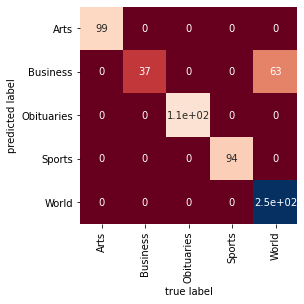

In [947]:
y_test =  prediction_df['actual']
predictions =  prediction_df['pred']

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=sections, yticklabels=sections)
plt.xlabel('true label')
plt.ylabel('predicted label')

## Notes

- Accuracy varies with different values of alpha and beta
- Looks like it could be overfitting

# Implement Naive Bayes Using Sklearn

In [536]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [525]:
model_df = final_df[['combined_text_cleaned','section_name']].copy()
model_df = model_df.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(model_df['combined_text_cleaned'],
                                                    model_df['section_name'], random_state=1)

In [527]:
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [562]:
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
word_freq_df['class'] = y_train 

In [641]:
# word count per section
for s in sections:
    df = word_freq_df[word_freq_df['class']==s].copy()
    df.drop('class',inplace=True,axis=1)
    df = df.sum().sort_values(0, ascending=False)
    print(s)
    print(df.head(10))
    print()

Arts
deaths         76
notable        74
coronavirus    52
said           47
times          44
world          43
week           39
art            38
year           38
president      36
dtype: int64

Business
deaths      68
notable     65
n           47
week        43
times       42
year        41
pandemic    38
world       36
people      35
season      35
dtype: int64

Obituaries
deaths         75
notable        66
times          55
n              54
world          49
week           38
s              35
coronavirus    35
l              34
pandemic       34
dtype: int64

Sports
deaths         64
notable        60
week           35
s              35
season         29
coronavirus    28
president      27
year           27
pandemic       26
day            25
dtype: int64

World
amazon           3
high             2
assails          2
virus            2
brazil           2
toll             2
exceptionally    2
taking           2
pandemic         2
region           2
dtype: int64



In [535]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_cv, y_train)
predictions = naive_bayes.predict(X_test_cv)

In [538]:
print('Accuracy score: ', accuracy_score(y_test, predictions))

Accuracy score:  0.9056


Text(91.68, 0.5, 'predicted label')

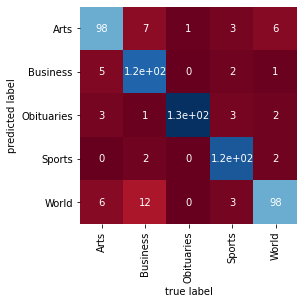

In [540]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=sections, yticklabels=sections)
plt.xlabel('true label')
plt.ylabel('predicted label')